<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [ ]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2098]:
import requests
import bs4
from bs4 import BeautifulSoup
from pprint import pprint
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as pltfrom 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_auc_score
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.api as sm

In [ ]:
## YOUR CODE HERE
response = requests.get(URL)

# checking the response
print('Status Code: ',response.status_code)

# pulling the html string
html = response.text

soup = BeautifulSoup(html, 'html.parser')

# print(soup.prettify())


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [ ]:
## YOUR CODE HERE

def extract_location_from_result(html_data):
    l=[]
    for item in html_data.find_all(name='span', class_='location'):
        try:
            location = item.text.strip('\n, ')
        except:
            location = None
        l.append(location)
    return l

def extract_company_from_result(html_data):
    l=[]
    for item in html_data.find_all(name='span', class_='company'):
        try:
            company = item.getText().strip('\n, ')
        except:
            company = None
        l.append(company)
    return l
    
def extract_jobtitle_from_result(html_data):
    l = []
    for item in html_data.find_all(name='h2', class_='jobtitle'):
        try:
            jobtitle = item.text.strip('\n, ')
        except:
            jobtitle = None
        l.append(jobtitle)
    return l

def extract_salary_from_result(html_data):
    l = []
    for item in html_data.find_all(name='td', class_='snip'):
        try:
            salary = item.find(name='span', class_='no-wrap').text.strip('\n, ')
        except:
            salary = None
        l.append(salary)
    return l

        
        
    

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [ ]:
# YOUR_CITY = 
# I've added San Diego, Boston and Pittsburgh instead of London

In [ ]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

csv_file = open('indeed_datascience_scrape_none.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['location', 'company', 'salary', 'job_title'])

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'San+Diego', 'Boston']):

    print(city)
    for start in tqdm(range(0, max_results_per_city, 10)):
        # Grab the results from the request (as above)
        # Append to the full set of results

        response = requests.get(url_template.format(city, start))
        
        # pulling the html string
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        
#         below functions returns lists including information from each result page
        location = extract_location_from_result(soup)
        company = extract_company_from_result(soup)
        salary = extract_salary_from_result(soup)
        job_title = extract_jobtitle_from_result(soup)
        
#         below loop reads the result lists and adds the location, company, salary and job_title information to the
# csv file

        for a in range(len(company)):
            
            csv_writer.writerow([location[a], company[a], salary[a], job_title[a]])
            a = 0
    
csv_file.close()

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [2693]:
## YOUR CODE HERE
df = pd.read_csv('indeed_datascience_scrape_n3.csv')
df.head()

,location,company,salary,job_title
0,"Chicago, IL 60601 (Loop area)",Allstate,NaN,Junior Business Analytics Consultant (Charlott...
1,"Chicago, IL 60647 (Logan Square area)",Coyote Logistics,NaN,Sr. Data Scientist
2,"Chicago, IL",PowerReviews,NaN,Business Intelligence Analyst
3,"Chicago, IL",McKinsey & Company,NaN,"Intern - Freshman Women in Computer Science, N..."
4,"Chicago, IL",McKinsey & Company,NaN,Analyst - Periscope Advanced Insights - Growth...


In [2694]:
df.tail()

,location,company,salary,job_title
89920,"Dallas, TX","JAMY INTERACTIVE,INC",NaN,Senior Data Scientist
89921,"Dallas, TX",Vet2Tech,NaN,Marketing Research Analyst
89922,"Dallas-Fort Worth, TX",RockBridge Search & Recruitment,NaN,ALM - Quantitative Risk Analyst
89923,"Dallas-Fort Worth, TX",RockBridge Search & Recruitment,NaN,Financial Risk - Quantitative Risk Analyst
89924,"Dallas, TX 75214 (Northeast Dallas area)",DIVERSANT LLC,NaN,Machine Learning (NLP) Engineer


In [2695]:
df.shape

(89925, 4)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [2696]:
## Dropping the rows null information.
df = df.dropna()
df.shape

(10604, 4)

In [2697]:
# Dropping duplicate rows
df = df.drop_duplicates(keep=False)
df.shape

(300, 4)

In [2698]:
# filtering annual salaries.
pl = ['hour', 'week', 'month', 'day']
for i in pl:
    df = df.loc[~df['salary'].str.contains(i)]

In [2699]:
df.shape

(230, 4)

In [2700]:
df = df.reset_index()

In [2701]:
# removing index column from the original file not to have confusion
df.pop('index')

0        166
1        167
2        203
3        381
4        406
5        409
6        410
7        413
8        414
9        415
10       455
11       465
12       476
13       525
14       526
15       533
16       543
17       545
18       547
19       559
20       566
21       587
22       627
23       630
24       648
25      4999
26      5009
27      5074
28      5227
29      5239
30      5277
31      9997
32     10004
33     10006
34     10007
35     10033
36     10049
37     10102
38     10103
39     10246
40     10314
41     14992
42     14995
43     15207
44     15402
45     15505
46     15509
47     19999
48     20006
49     20056
50     20083
51     25159
52     25160
53     25161
54     25162
55     25163
56     25164
57     25168
58     25215
59     25220
60     30020
61     30021
62     30138
63     30142
64     30148
65     30153
66     30155
67     30163
68     30190
69     30191
70     30195
71     30197
72     34992
73     35030
74     35041
75     35063
76     39975

In [2702]:
df.head()

,location,company,salary,job_title
0,"Chicago, IL",Jobspring Partners,"$170,000 - $220,000 a year",Principal Machine Learning Engineer
1,"Chicago, IL",Workbridge Associates,"$130,000 - $180,000 a year",Machine Learning Architect
2,"Chicago, IL",All-In Analytics,"$120,000 - $130,000 a year",Sr. Model Validation Analyst
3,"Chicago, IL",Workbridge Associates,"$80,000 - $110,000 a year","Data Engineer (C#, Azure, NoSQL)"
4,"Chicago, IL",Workbridge Associates,"$80,000 - $110,000 a year",Data Scientist


In [2703]:
# splitting location into city and state
df = df.join(df['location'].str.split(',', 1, expand=True).rename(columns={0:'city', 1:'state'}))

In [2704]:
df.state.unique()

array([' IL', ' IL 60601 (Loop area)', ' IL 60654 (Loop area)',
       ' IL 60605 (Near South Side area)', ' GA',
       ' GA 30303 (Five Points area)', ' CA', ' CA 92121', ' CO', ' PA',
       ' TX', ' TX 75024', ' TX 75219 (Oak Lawn area)', ' TX 75086',
       ' TX 75051', ' TX 78759 (Arboretum area)',
       ' TX 78758 (North Austin area)', ' TX 78731', ' AZ',
       ' AZ 85251 (South Scottsdale area)', ' TX 77002 (Downtown area)',
       ' TX 77032', ' WA 98052', ' WA', ' WA 98004 (Downtown area)',
       ' WA 98332', ' WA 98109 (Westlake area)', ' MA',
       ' MA 02116 (South End area)', ' OR',
       ' CA 94108 (Financial District area)',
       ' CA 94103 (South Of Market area)',
       ' CA 94607 (Acorn-Acorn Industrial area)', ' CA 94080',
       ' CA 94107 (South Of Market area)', ' CA 94066',
       ' CA 94114 (Castro-Upper Market area)', ' FL',
       ' FL 33315 (River Oaks area)', ' DE',
       ' PA 19147 (Wharton-Hawthorne-Bella Vista area)',
       ' PA 19103 (Belmont a

In [2705]:
# cleaning the state column of the area information and the spaces.
df.state = df.state.str.slice(start=0, stop=3)
df.state = df.state.str.strip(' ')
df.state.unique()

array(['IL', 'GA', 'CA', 'CO', 'PA', 'TX', 'AZ', 'WA', 'MA', 'OR', 'FL',
       'DE', 'NY', None], dtype=object)

<b>NOTE:</b> 2 New York entires has 'New York State' as the city and thus the value for State column for these entries is None. I'll replace the city with New York and the column values with NY before I continue with the further cleaning.

In [2706]:
df.state = df['state'].fillna('NY')
df.state.value_counts()

CA    56
TX    43
IL    25
NY    25
MA    18
PA    18
FL    14
WA    11
GA     6
CO     6
AZ     4
OR     2
DE     2
Name: state, dtype: int64

In [2709]:
# combining the small areas with the bigger cities nearby
citydict = {'Plano': 'Dallas', 
            'Kennesaw': 'Atlanta', 
            'League City': 'Houston', 
            'Alpharetta':'Atlanta',
            'Broomfield':'Denver',
            'Commerce': 'Los Angeles',
            'Englewood': 'Denver',
            'Emeryville': 'San Francisco',
            'Saint Paul': 'Minneapolis',
            'Jonesboro': 'Atlanta',
            'Wilmington': 'Philadelphia',
            'Anaheim': 'Los Angeles',
            'Duluth': 'Atlanta',
            'Rensselaer': 'Albany',
            'Richardson': 'Dallas',
            'Playa Vista': 'Los Angeles',
            'Mount Laurel': 'Philadelphia',
            'Spring': 'Houston',
            'Tempe': 'Tuscon',
            'Belmont': 'San Francisco',
            'South San Francisco': 'San Francisco',
            'Los Angeles County': 'Los Angeles',
            'Oak Brook': 'Chicago',
            'Conshohocken': 'Philadelphia',
            'El Segundo': 'Los Angeles',
            'Irving': 'Dallas',
            'Santa Monica': 'Los Angeles',
            'Arlington': 'Dallas',
            'Lisle': 'Chicago',
            'Stony Brook': 'New York',
            'Bothell': 'Seattle',
            'Lakewood': 'Denver',
            'Venice': 'Los Angeles',
            'Oakland': 'San Francisco',
            'Berkeley': 'San Francisco',
            'Redwood City': 'San Francisco',
            'Beaverton': 'Portland',
            'Scottsdale': 'Phoenix',
            'Redmond': 'Seattle',
            'Bellevue': 'Seattle',
            'Coral Gables': 'Miami',
            'Manhattan': 'New York',
            'Queens': 'New York',
            'New York State': 'Albany',
            'Orient': 'New York',
            'Fort Washington': 'Philadelphia',
            'Grand Prairie': 'Dallas',
            'Gig Harbor': 'Seattle',
            'Evanston': 'Chicago',
            'Oakbrook Terrace': 'Chicago',
            'Fort Gillem': 'Atlanta',
            'Aventura': 'Miami',
            'Fort Lauderdale': 'Miami',
            'Buckley AFB': 'Denver',
            'Glendale': 'Denver',
            'Cypress':'Long Beach',
            'Downey': 'Long Beach',
            'Duarte': 'Los Angeles',
            'Encinitas': 'San Diego',
            'Pasadena': 'Los Angeles',
            'Redondo Beach': 'Long Beach',
            'San Bruno':'San Francisco',
            'San Mateo':'San Francisco',
            'Cambridge': 'Boston',
            'Tuscon': 'Phoenix' 
           }

def replacecity(x):
    if x in citydict.keys():
        truecity = citydict[x] 
    else:
        truecity = x
    return truecity

df['city'] = df['city'].map(replacecity)

In [2710]:
pd.set_option('display.max_rows',None)
df.groupby(['state','city'])['city'].size()

state  city         
AZ     Phoenix           4
CA     Long Beach        5
       Los Angeles      10
       San Diego        10
       San Francisco    31
CO     Boulder           1
       Denver            5
DE     Philadelphia      2
FL     Miami            14
GA     Atlanta           6
IL     Chicago          25
MA     Boston           18
NY     Albany            7
       New York         18
OR     Portland          2
PA     Philadelphia     14
       Pittsburgh        4
TX     Austin           12
       Dallas           11
       Houston          20
WA     Seattle          11
Name: city, dtype: int64

In [2711]:
df.state = df.state.str.replace('DE', 'PA')
df.state.unique()

array(['IL', 'GA', 'CA', 'CO', 'PA', 'TX', 'AZ', 'WA', 'MA', 'OR', 'FL',
       'NY'], dtype=object)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [2712]:
## YOUR CODE HERE
def clean_salary(df, column):
    
# removing a year, (Indeed est.), $ strings from the final data points
    str_list = ['a year', '(Indeed est.)', '$']
    for i in str_list:
        df[column] = df[column].map(lambda x: x.replace(i, ''))

# Splitting the range of values 
    df = df.join(df[column].str.split('-', 1, expand=True).rename(columns={0:'lowest', 1:'highest'}))

# removing commas 
    df['lowest'] = df['lowest'].str.replace(',', '')
    df['highest'] = df['highest'].str.replace(',', '')

# checking for the missing values
    if df['lowest'].isna().sum()> 0:
        df['lowest'] = df['lowest'].fillna(0)
    elif df['highest'].isna().sum()>0:
        df['highest'] = df['highest'].fillna(0)

# converting them to a numeric data type
    df.lowest = df.lowest.astype(int)
    df.highest = df.highest.astype(int)

# assigning the mean of the salary range back to the salary column
    df[column] = df[['lowest', 'highest']].mean(axis=1)
    return df[column]

In [2713]:
df.salary = clean_salary(df, 'salary')
df.head()

,location,company,salary,job_title,city,state
0,"Chicago, IL",Jobspring Partners,195000.0,Principal Machine Learning Engineer,Chicago,IL
1,"Chicago, IL",Workbridge Associates,155000.0,Machine Learning Architect,Chicago,IL
2,"Chicago, IL",All-In Analytics,125000.0,Sr. Model Validation Analyst,Chicago,IL
3,"Chicago, IL",Workbridge Associates,95000.0,"Data Engineer (C#, Azure, NoSQL)",Chicago,IL
4,"Chicago, IL",Workbridge Associates,95000.0,Data Scientist,Chicago,IL


### Save your results as a CSV

It has already been saved while scraping.

<b>EXPLORATIVE ANALYSES</b>

In [2714]:
df.describe()

,salary
count,230.000000
mean,98885.147826
std,43307.160364
min,20000.000000
25%,67687.000000
50%,97436.000000
75%,127875.000000
max,250000.000000


In [2715]:
df.salary.median()

97436.0

As the below distribution plot indicates, salary variable has a fairly normally distributed with a mean of 98885.1 and median of 97436.0, although a few high salaries on the upper end of the distribution seem to gives it a little positive skew. 

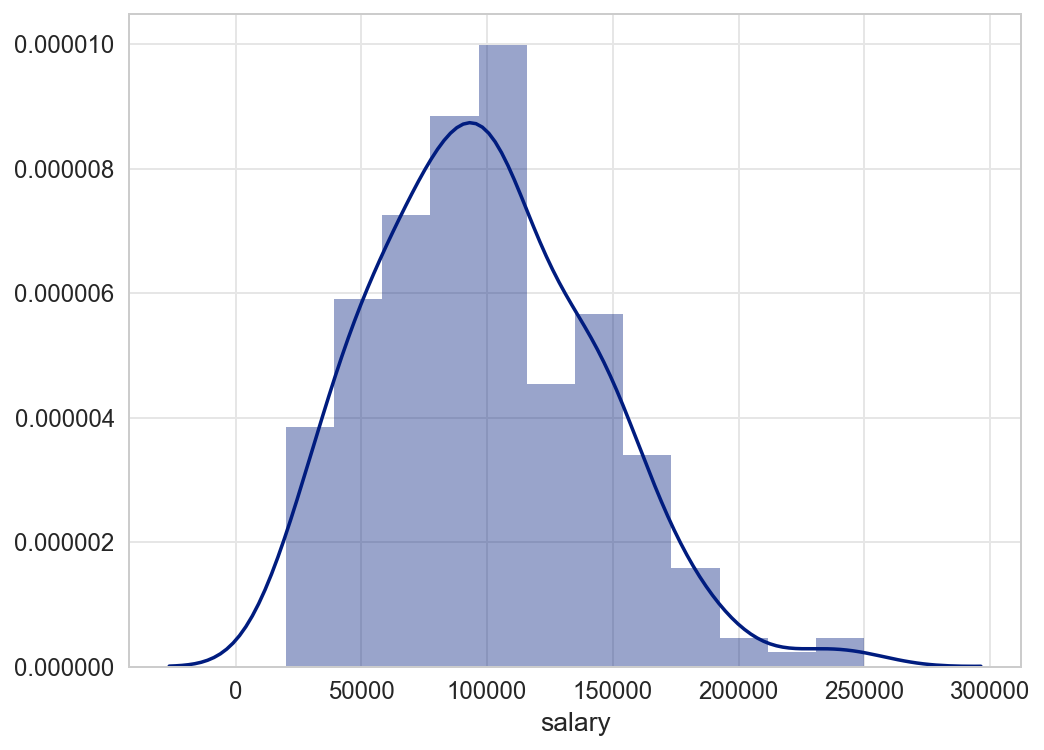

In [2716]:
sns.set_palette(sns.diverging_palette(220, 20, n=7))
sns.set(color_codes=True,rc={"figure.figsize": (8, 6), 'grid.color': '0.9'}, palette = 'dark',
        style = 'whitegrid', font_scale = 1.2)
sns.distplot(df['salary'], hist=True, kde=True);


Below plots represent the number of entries and the mean salary distributions of each state, respectively. According to the plots, NY and TX has more observations in this dataset. When we look at the bar plot on the right, however, it's very clear that the jobs from WA state has very high salaries within this dataset which reflects on the average salary distribution. 

On the other hand only 4 state average salaries seem to be over the median salary score. These states are IL, CA, WA, MA.

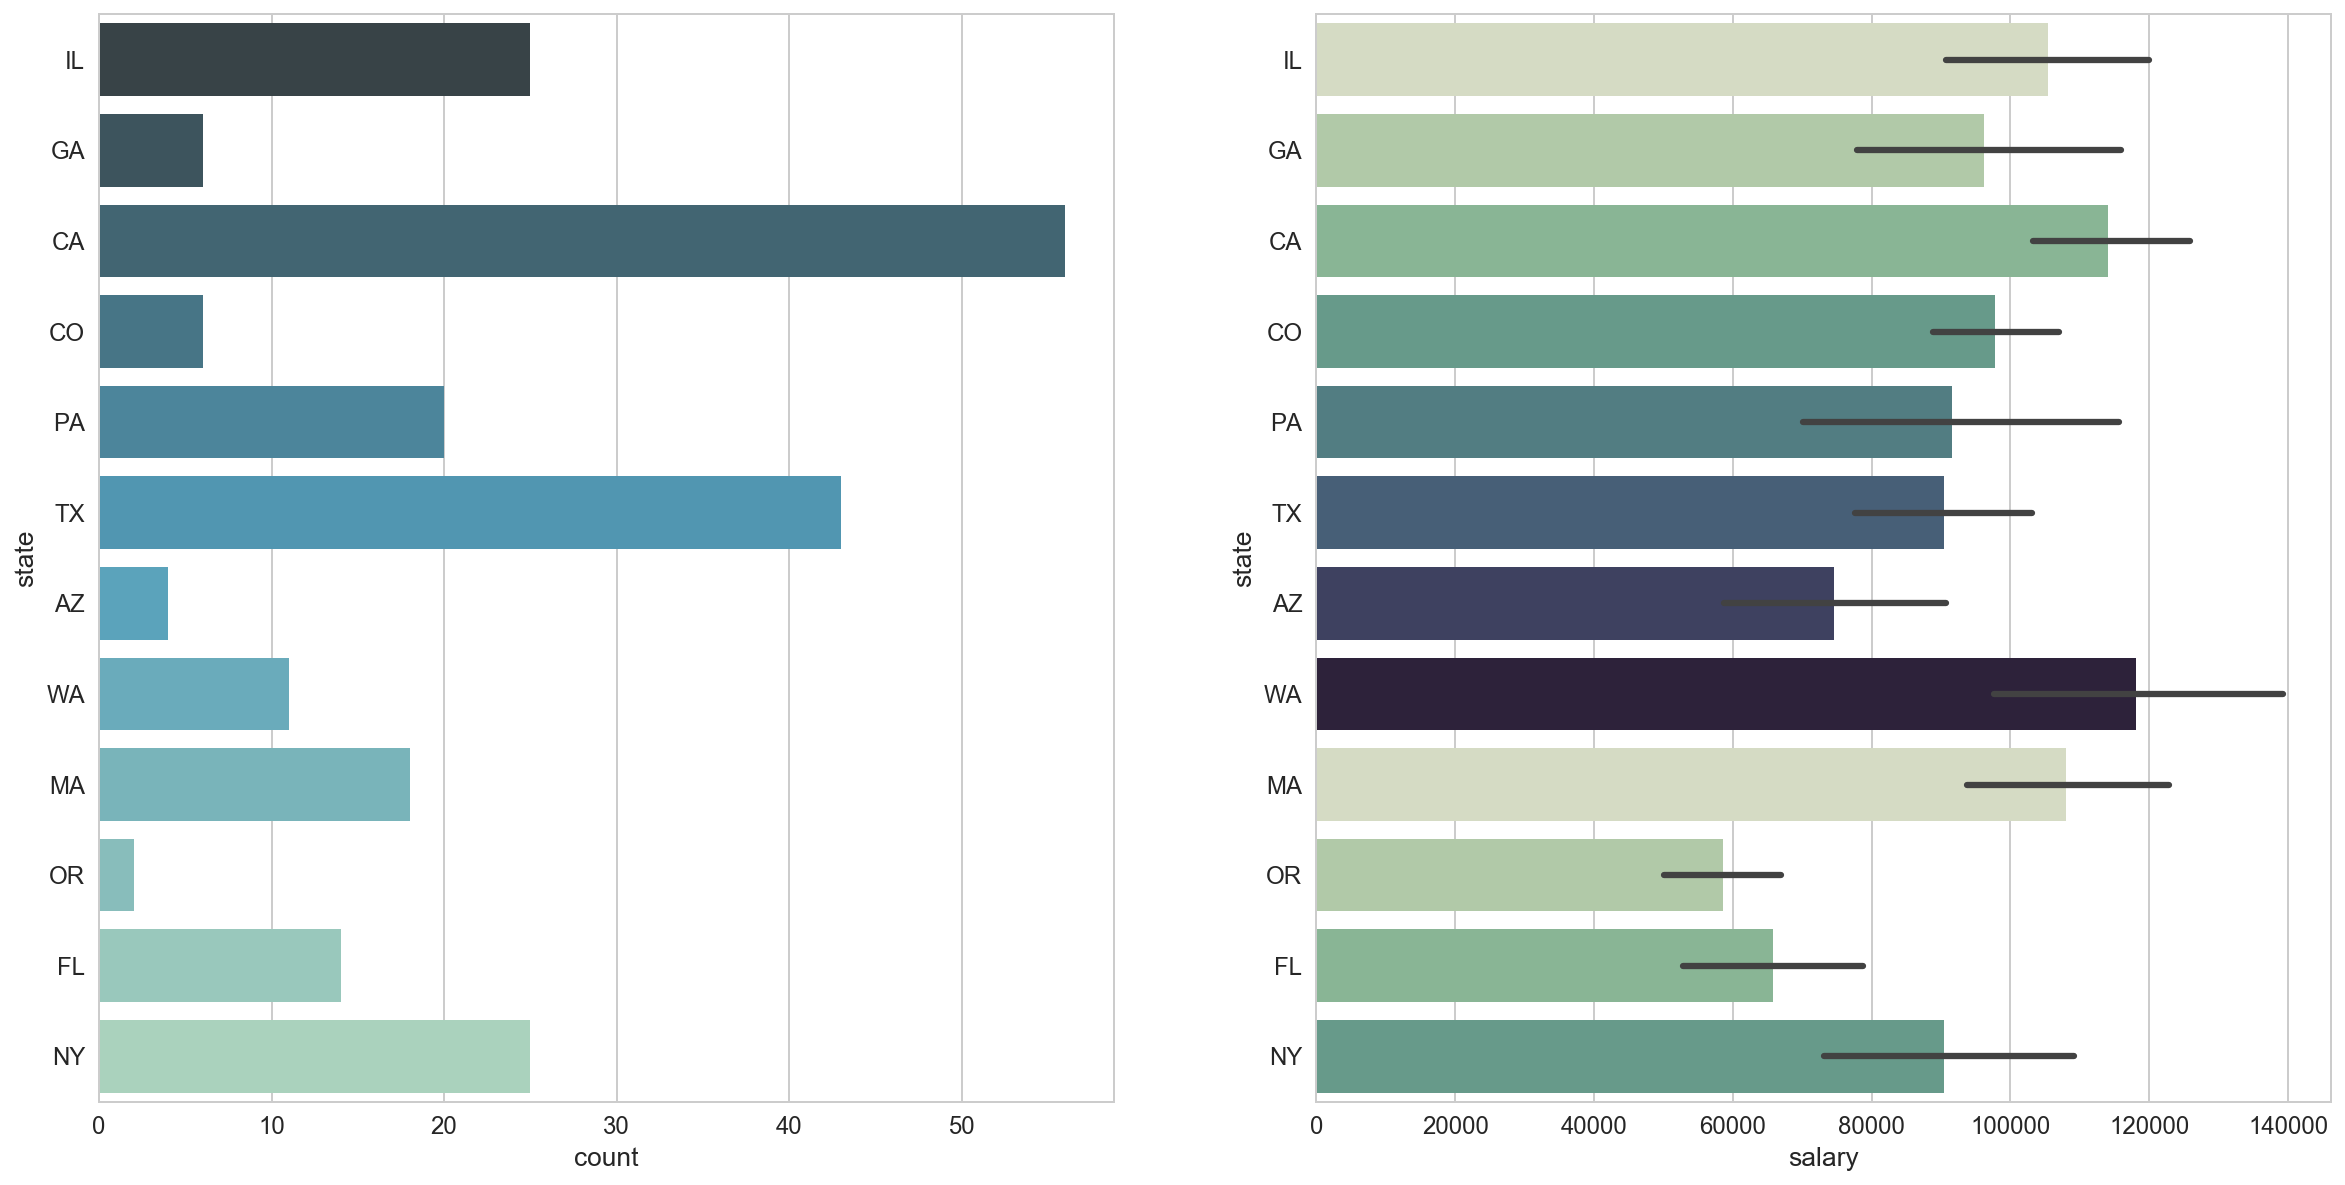

In [2717]:
c_palette = sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1 = ax[0]
ax2 = ax[1]
sns.countplot(y = 'state', orient="h", data=df, palette='GnBu_d', ax=ax1);
sns.barplot(y = 'state',  x = 'salary', orient="h", data=df, palette=c_palette, ax=ax2);

I have generated the same plots for the cities as well in order to see how different cities in the above states distributed with the salary average. As can be seen below, San Francisco has the most data points followed by Chicago. 
As expected Seattle has a very close mean to San Francisco salary mean, followed by Boston, Chicago and New York.

As there's more variation in the average salaries of the cities in comparison to the state salaries, I'll be using cities as the location variable of my analyses. I think it's more interesting to see how different cities will perform within a model to predict higher salaries.

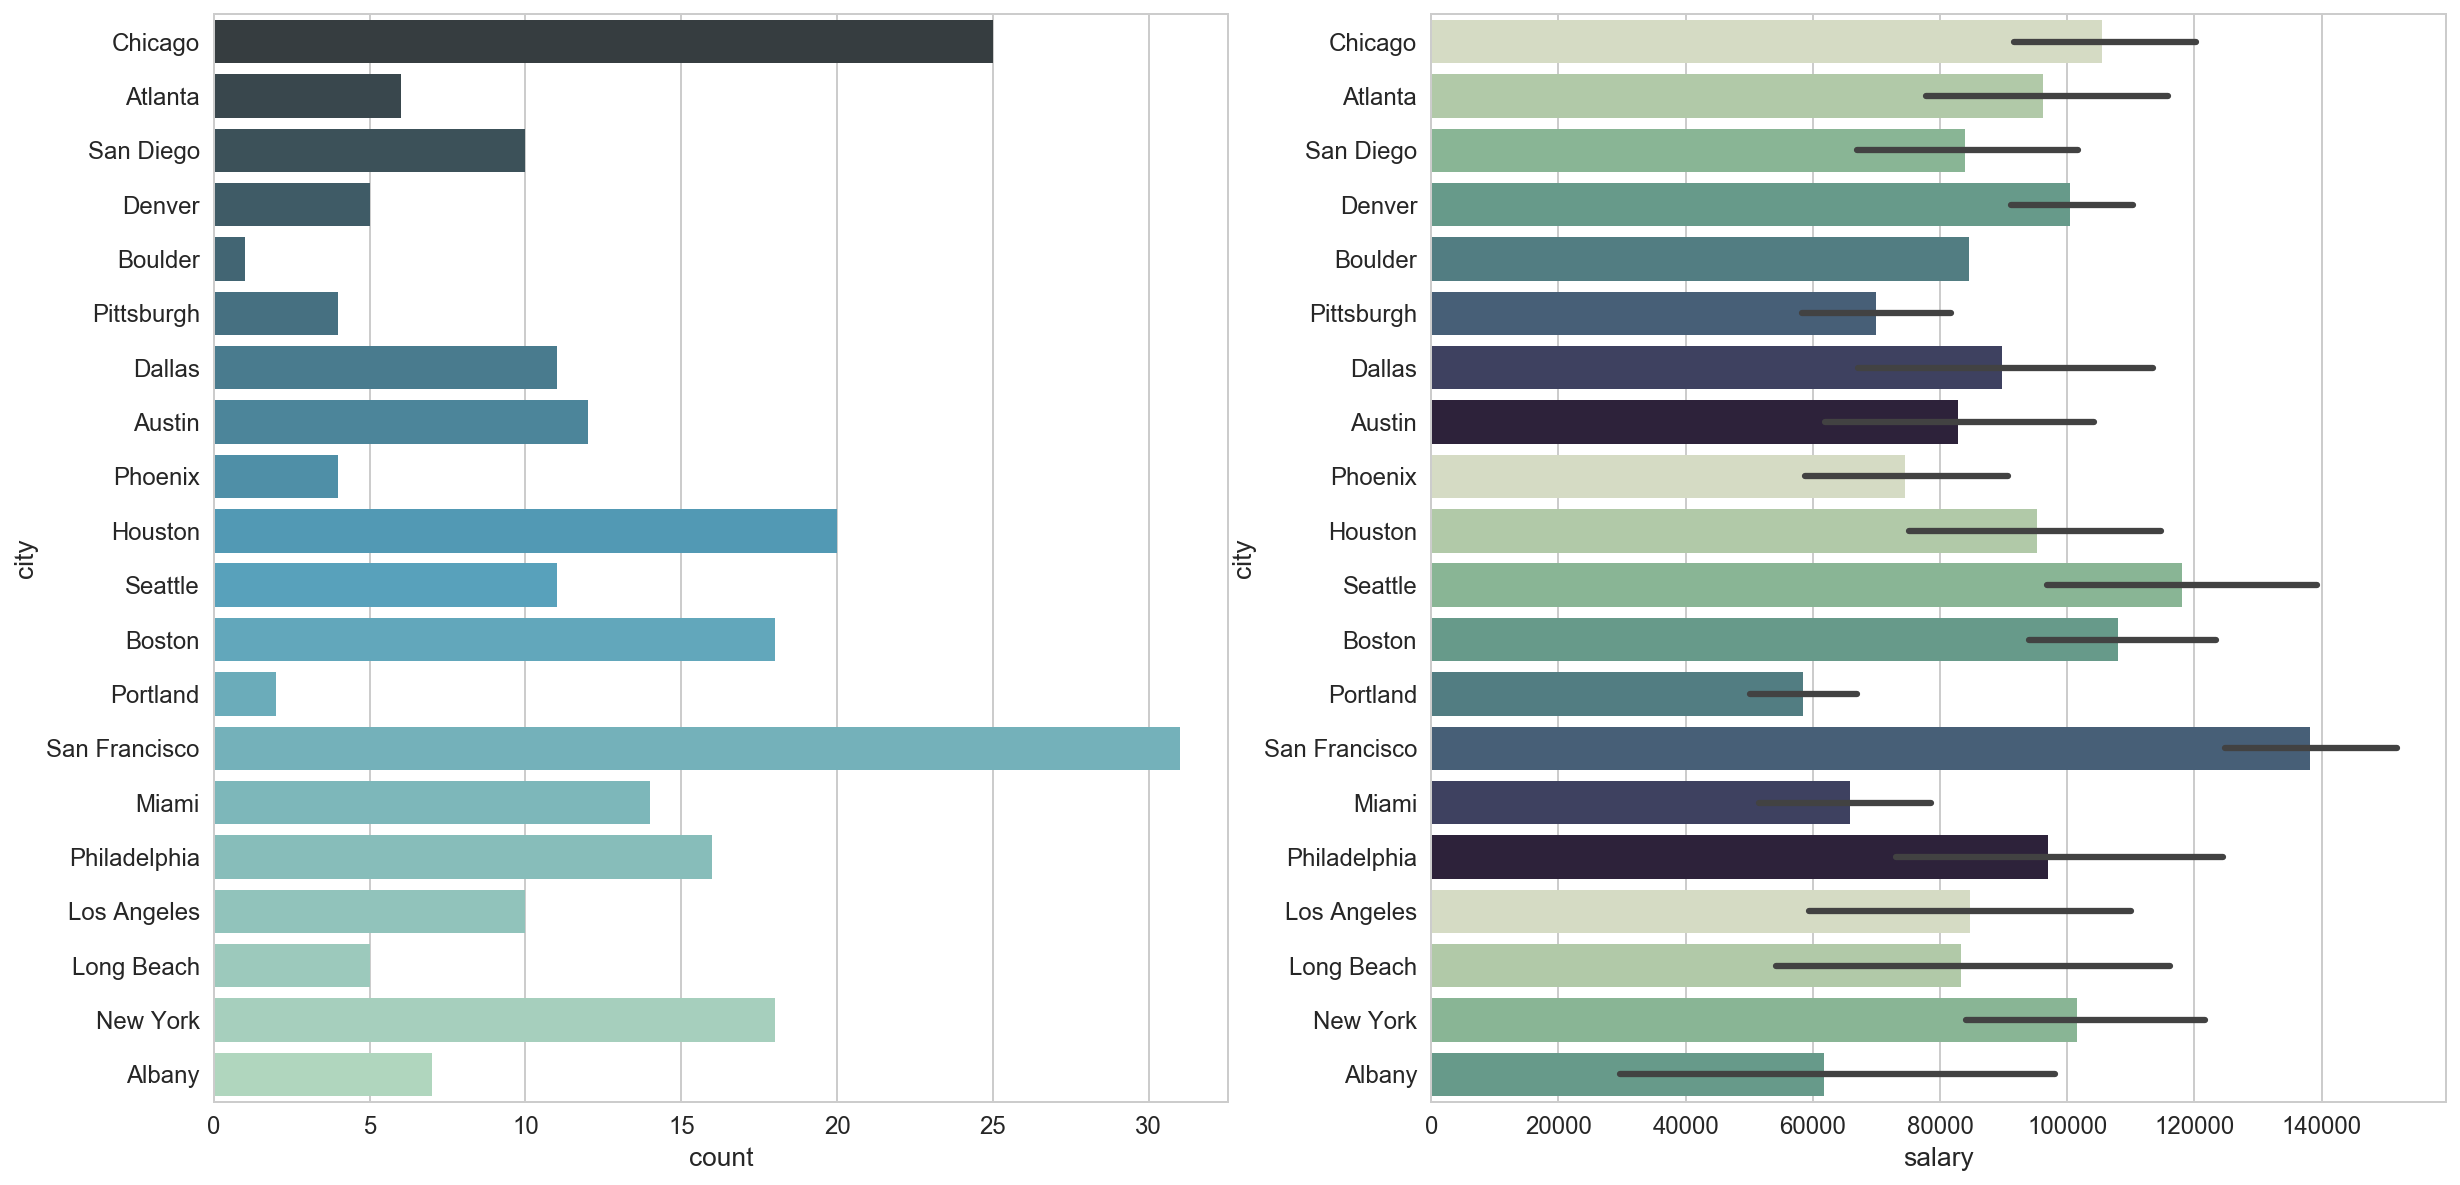

In [2718]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1 = ax[0]
ax2 = ax[1]
sns.countplot(y = 'city', orient="h", data=df, palette='GnBu_d', ax=ax1);
sns.barplot(y = 'city',  x = 'salary', orient="h", data=df, palette=c_palette, ax=ax2);

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

#### Load in the the data of scraped salaries

In [2719]:
# Changing Sr. and Jr. titles to Senior and Junior
df.job_title = df.job_title.str.replace('Sr.', 'Senior')
df.job_title = df.job_title.str.replace('Jr.', 'Junior')

In [2720]:
## Creating new features with the job title and the level of the position
jobt = ['Data', 'Scientist', 'Analyst', 'Research', 'Engineer',  'Machine', 'Modeling', 'Statistic',
        'Senior', 'Junior', 'Staff', 'Director', 'Manager', 'Intern', 'Principal']

for i in jobt:
    df['title_'+i] =np.ones
    for j, m in enumerate(df.job_title.get_values()):

        if i in m:       
            df.loc[j,['title_'+i]] = 1
        else:
            df.loc[j,['title_'+i]] = 0

In [2721]:
df.head(4)

,location,company,salary,job_title,city,state,title_Data,title_Scientist,title_Analyst,title_Research,...,title_Machine,title_Modeling,title_Statistic,title_Senior,title_Junior,title_Staff,title_Director,title_Manager,title_Intern,title_Principal
0,"Chicago, IL",Jobspring Partners,195000.0,Principal Machine Learning Engineer,Chicago,IL,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,"Chicago, IL",Workbridge Associates,155000.0,Machine Learning Architect,Chicago,IL,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,"Chicago, IL",All-In Analytics,125000.0,Senior Model Validation Analyst,Chicago,IL,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,"Chicago, IL",Workbridge Associates,95000.0,"Data Engineer (C#, Azure, NoSQL)",Chicago,IL,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [2722]:
# median of the salary variable
med = df.salary.median()
med

97436.0

In [2723]:
mean = df.salary.mean()
mean

98885.14782608696

In [2724]:
## Creating a binary salary variable. 1 represents higher salaries whereas 0 represents the lower salaries
df['sal'] = np.ones
for m, j in enumerate(df.salary.get_values()):
    if j < med:
        df.loc[m,['sal']] = 0
    else:
        df.loc[m,['sal']] = 1
df.head(4)

,location,company,salary,job_title,city,state,title_Data,title_Scientist,title_Analyst,title_Research,...,title_Modeling,title_Statistic,title_Senior,title_Junior,title_Staff,title_Director,title_Manager,title_Intern,title_Principal,sal
0,"Chicago, IL",Jobspring Partners,195000.0,Principal Machine Learning Engineer,Chicago,IL,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,"Chicago, IL",Workbridge Associates,155000.0,Machine Learning Architect,Chicago,IL,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"Chicago, IL",All-In Analytics,125000.0,Senior Model Validation Analyst,Chicago,IL,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,"Chicago, IL",Workbridge Associates,95000.0,"Data Engineer (C#, Azure, NoSQL)",Chicago,IL,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Thought experiment: What is the baseline accuracy for this model?

Baseline accuracy for this model is 0.5 which is no better than the random guess. In order for a prediction model to be deemed as good, we expect it to have a higher accuracy than the baseline and of course from the random guess.

In [2725]:
df.sal.mean()

0.5

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC curve for at least one of your models.

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC curves for the different models you studied (at least the tuned model of each category) and compare.

<b>Proportions of higher salaries for each city</b>

According to the below table and the corresponding factor plot, San Francisco has the higher proportion of the higher salaries in this dataset followed by Seattle, Atlanta, Chicago and Denver. I'll drop Houston from the analyses as it seems to be in the middle in terms of the high salary proportion to see how other cities are effecting the high salary in comparison to Houston.

In [2726]:
df.groupby('city')[['sal']].mean().sort_values(by='sal', ascending=False)

,sal
city,
San Francisco,0.870968
Seattle,0.818182
Atlanta,0.666667
Chicago,0.640000
Denver,0.600000
Boston,0.500000
Dallas,0.454545
Houston,0.450000
Philadelphia,0.437500


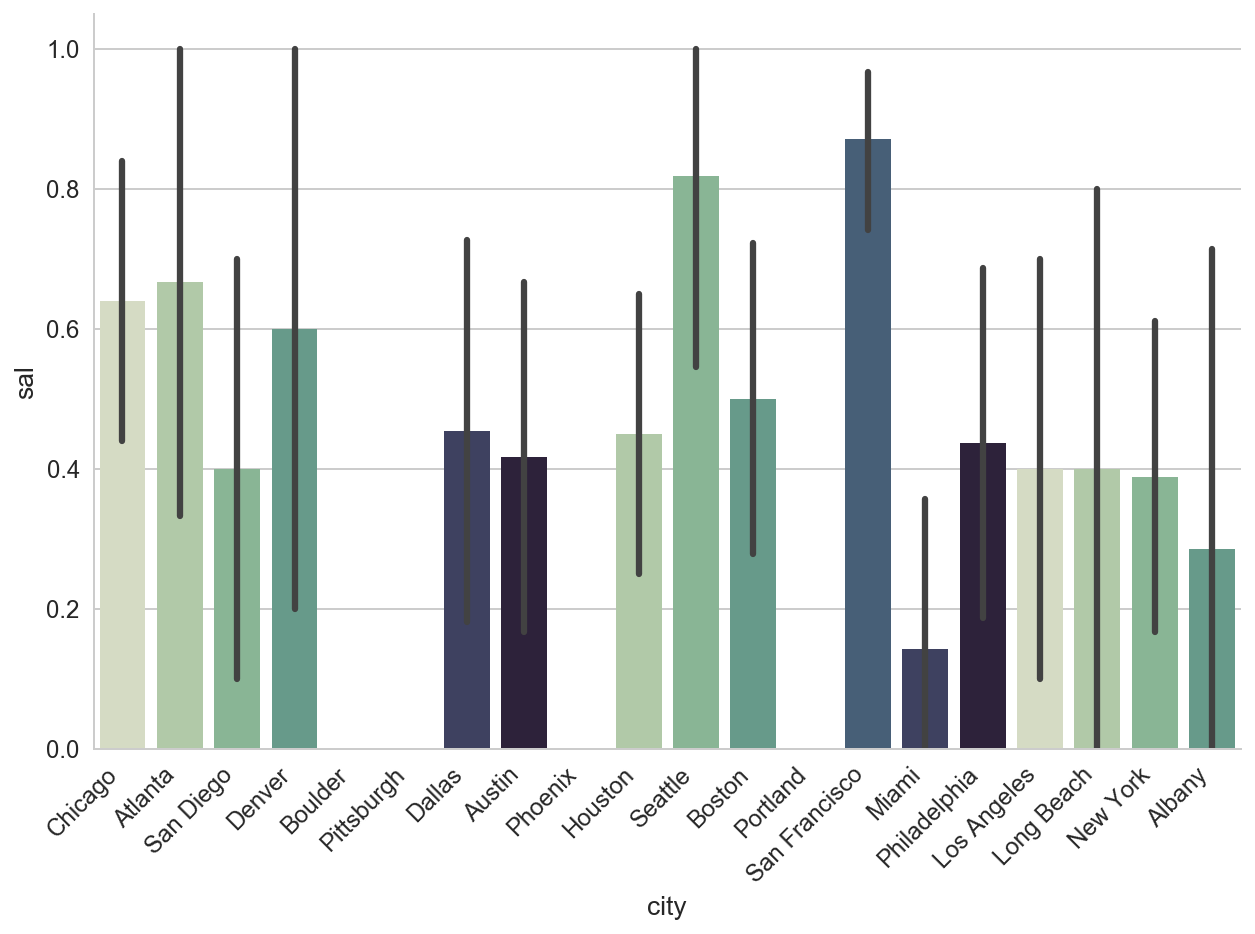

In [2727]:
sns.factorplot(x='city', y='sal', data=df, kind='bar', 
               palette=c_palette, size=6, aspect=1.5).set_xticklabels(rotation=45, horizontalalignment='right');

<b>LOGISTIC REGRESSION WITH STATSMODELS</b>

In [2728]:
import statsmodels.formula.api as sm
mod1 = sm.logit("sal~C(city, Treatment('Houston'))",data=df).fit(method='lbfgs')
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sal   No. Observations:                  230
Model:                          Logit   Df Residuals:                      210
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Apr 2018   Pseudo R-squ.:                  0.1697
Time:                        19:01:04   Log-Likelihood:                -132.37
converged:                       True   LL-Null:                       -159.42
                                        LLR p-value:                 3.188e-05
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -0.2006      0.449     -0.446      0.655      -1.082       0.680
C(city, Treatment('Houston'))[T.Albany]           -0.7160      0.950     -0.754      0.451      -2.578       1.146
C(city, Treatment('Houston'))[T.Atlanta]           0.8937      0.976      0.916      0.360      -1.019       2.806
C(city, Treatment('Houston'))[T.Austin]           -0.1359      0.738     -0.184      0.854      -1.583       1.311
C(city, Treatment('Houston'))[T.Boston]            0.2007      0.651      0.308      0.758      -1.076       1.477
C(city, Treatment('Houston'))[T.Boulder]         -11.5292    352.461     -0.033      0.974    -702.339     679.281
C(city, Treatment('Houston'))[T.Chicago]           0.7761      0.613      1.266      0.205      -0.425       1.977
C(city, Treatment('Houston'))[T.Dallas]            0.0182      0.754      0.024      0.981      -1.460       1.496
C(city, Treatment('Houston'))[T.Denver]            0.6068      1.018      0.596      0.551      -1.388       2.601
C(city, Treatment('Houston'))[T.Long Beach]       -0.2062      1.018     -0.203      0.839      -2.201       1.788
C(city, Treatment('Houston'))[T.Los Angeles]      -0.2049      0.787     -0.261      0.794      -1.747       1.337
C(city, Treatment('Houston'))[T.Miami]            -1.5909      0.886     -1.795      0.073      -3.328       0.146
C(city, Treatment('Houston'))[T.New York]         -0.2518      0.660     -0.381      0.703      -1.546       1.042
C(city, Treatment('Houston'))[T.Philadelphia]     -0.0504      0.675     -0.075      0.940      -1.374       1.273
C(city, Treatment('Houston'))[T.Phoenix]         -16.9912   2704.724     -0.006      0.995   -5318.153    5284.171
C(city, Treatment('Houston'))[T.Pittsburgh]      -16.9912   2704.724     -0.006      0.995   -5318.153    5284.171
C(city, Treatment('Houston'))[T.Portland]        -14.5599   1134.194     -0.013      0.990   -2237.540    2208.420
C(city, Treatment('Houston'))[T.San Diego]        -0.2049      0.787     -0.261      0.794      -1.747       1.337
C(city, Treatment('Houston'))[T.San Francisco]     2.1099      0.699      3.017      0.003       0.739       3.481
C(city, Treatment('Houston'))[T.Seattle]           1.7049      0.902      1.891      0.059      -0.063       3.472
==================================================================================================================
"""

<b>Confusion Matrix at the threshold level 0.5</b>

As mod1.pred_table(threshold=0.5) returns a confusion matrix with values on a different axis, I'll extract results manually.

Explanation on the manual:

'pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal.'

In [2787]:
# prediction table
ar = mod1.pred_table(threshold=0.5)

tp = ar[1,1]
fp = ar[1,0]
tn = ar[0,0]
fn = ar[0,1]

print('True Positive Rate - Recall:', tp/(tp+fn))
print('Positive Predictive Value - Precision:', tp/(tp+fp))
print('False Positive Rate:', fp/(fp+tn))
print('True Negative Rate: ', tn/(tn+fp))
print('Accuracy Score:', (tp+tn)/(tp+tn+fp+fn))

True Positive Rate - Recall: 0.7083333333333334
Positive Predictive Value - Precision: 0.591304347826087
False Positive Rate: 0.35074626865671643
True Negative Rate:  0.6492537313432836
Accuracy Score: 0.6739130434782609


<b>Confusion Matrix at the threshold level 0.4</b>

In [2788]:
ar2 = mod1.pred_table(threshold=0.4)

tp = ar2[1,1]
fp = ar2[1,0]
tn = ar2[0,0]
fn = ar2[0,1]

print('True Positive Rate - Recall:', tp/(tp+fn))
print('Positive Predictive Value - Precision:', tp/(tp+fp))
print('False Positive Rate:', fp/(fp+tn))
print('True Negative Rate: ', tn/(tn+fp))
print('Accuracy Score:', (tp+tn)/(tp+tn+fp+fn))

True Positive Rate - Recall: 0.6064516129032258
Positive Predictive Value - Precision: 0.8173913043478261
False Positive Rate: 0.28
True Negative Rate:  0.72
Accuracy Score: 0.6434782608695652


<b>Results of Logistic Regression with StatsModels </b>

Logistic Regression model with using 19 cities as predictors excluding Houston returned an accuracy score of 0.67 at the 0.5 probability threshold level. Overall, the model accuracy is above the baseline accuracy (0.5). Even though the model have not performed very well in predicting salaries with only using the location as a factor, it's expected given that the small number of valid observations in the scraped data required for this analyses.

At the 0.5 probability threshold, the model has a 0.70 recall, but a 0.63 precision, indicating that when the model classified a salary as high, it was correct 63% of the time. Whereas overall 83% of the high salaries have been classified correctly. When the prediction threshold was reduced to 0.4, the model has a higher precision (81%) and a lower recall (60%). Although the accuracy was reduced a little with this threshold change, this better corresponds to the concerns of making incorrect true predictions. 

Houston has a negative coefficient of -0.2 with a p score of 0.65 indicating that it is not a very good predictor in terms of predicting the higher salaries.

All the other city coefficients and p values are calculated in their effectiveness of predicting higher salaries in comparison to the dropped variable, Houston. Looking at the results, we can see that some cities have very high negative coefficients such as Boulder, Phoenix, Pittsburgh and Portland. The negative values indicates that the observations in the datasets seem to predict lower salaries. However, it's not possible to make a conclusion about the salary range in these cities with the current dataset, as it includes very few observation from these locations.

Cities like Atlanta, Boston, Denver and Chicago are not significantly different than Houston in their contribution to the prediction. However, positive coefficients indicate that the salaries in these cities represented in the dataset are more likely be in the higher salary range.

Only City that is significantly differs from Houston at p<0.05 level is San Francisco. Given the positive coefficient of 2.10, it's fair to say that the salaries in San Francisco are ten times more likely to be in the above median category range than Houston.

Seattle also have a very low p value (0.06) which we can conclude as the jobs in Seattle is almost 8 times more likely to be in the higher range category comparing to Houston.

<b>LOGISTIC REGRESSION WITH SKLEARN</b>

In [2795]:
from sklearn.model_selection import GridSearchCV

In [2796]:
mod_df = df[['sal','city']]
mod_df = pd.get_dummies(mod_df)
mod_df = mod_df.drop('city_Houston', axis=1)

In [2797]:
X = mod_df[['city_Albany', 'city_Atlanta', 'city_Austin', 'city_Boston',
       'city_Boulder', 'city_Chicago', 'city_Dallas', 'city_Denver',
     'city_Long Beach', 'city_Los Angeles', 'city_Miami',
       'city_New York', 'city_Philadelphia', 'city_Phoenix', 'city_Pittsburgh',
       'city_Portland', 'city_San Diego', 'city_San Francisco',
       'city_Seattle']]
y = mod_df['sal']

In [2798]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=5, stratify=y)

In [2799]:
gs_params = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.logspace(-5,3,50)}
mod_2 = GridSearchCV(LogisticRegression(), gs_params, n_jobs=-1, cv=3, verbose=1)
mod_2.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([1.00000e-05, 1.45635e-05, 2.12095e-05, 3.08884e-05, 4.49843e-05,
       6.55129e-05, 9.54095e-05, 1.38950e-04, 2.02359e-04, 2.94705e-04,
       4.29193e-04, 6.25055e-04, 9.10298e-04, 1.32571e-03, 1.93070e-03,
       2.81177e-0... 1.04811e+02, 1.52642e+02,
       2.22300e+02, 3.23746e+02, 4.71487e+02, 6.86649e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [2800]:
# Model Scores, best parameters and the intercept
print('Best Model Score:', mod_2.best_score_)
print('Best Parameters:', mod_2.best_params_)
print('Accuracy Score:', mod_2.best_estimator_.score(X_test, y_test))
print('Coefficient for Houston:', mod_2.best_estimator_.intercept_)

Best Model Score: 0.5844155844155844
Best Parameters: {'C': 0.5428675439323859, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy Score: 0.6842105263157895
Coefficient for Houston: [-0.10970502]


In [2801]:
coef_df = pd.DataFrame({'coef': mod_2.best_estimator_.coef_[0], 'feature': X_train.columns, 
            'abs_coef': np.abs(mod_2.best_estimator_.coef_[0])})
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df

,abs_coef,coef,feature
17,1.182638,1.182638,city_San Francisco
10,0.486306,-0.486306,city_Miami
18,0.404229,0.404229,city_Seattle
5,0.312841,0.312841,city_Chicago
14,0.048554,-0.048554,city_Pittsburgh
13,0.048554,-0.048554,city_Phoenix
16,0.000000,0.000000,city_San Diego
15,0.000000,0.000000,city_Portland
12,0.000000,0.000000,city_Philadelphia
11,0.000000,0.000000,city_New York


In [2294]:
mod_2_yhat = mod_2.best_estimator_.predict(X_test)
confusion = confusion_matrix(y_test,mod_2_yhat,labels=[1,0])
pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])

,pred_high_sal,pred_low_sal
high_sal,20,18
low_sal,6,32


In [2417]:
# calculating auc score
prob_l = mod_2.best_estimator_.predict_proba(X_test)
print('auc score:', roc_auc_score(y_test, prob_l[:,1]))

auc score: 0.7236842105263158


In [2367]:
# classification report of the Logistic Regression Model
print(classification_report(y_test, mod_2_yhat, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.77      0.53      0.62        38
          0       0.64      0.84      0.73        38

avg / total       0.70      0.68      0.68        76



<b>Results at the 0.7 Threshold</b>

In [2427]:
predictions_for_70 = (mod_2.best_estimator_.predict_proba(X_test)[:,1]>0.7)*1

In [2457]:
confusion = confusion_matrix(y_test, predictions_for_70, labels=[1,0])
conf = pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])
conf

,pred_high_sal,pred_low_sal
high_sal,11,27
low_sal,1,37


In [2464]:
# calculating new rates to plot them lates
nfpr = conf.loc['high_sal', 'pred_low_sal']/(conf.loc['high_sal', 'pred_low_sal']+conf.loc['low_sal', 'pred_low_sal'])
ntpr = conf.loc['high_sal', 'pred_high_sal']/(conf.loc['high_sal', 'pred_high_sal']+conf.loc['low_sal', 'pred_high_sal'])

In [2462]:
print(classification_report(y_test, predictions_for_80, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.92      0.29      0.44        38
          0       0.58      0.97      0.73        38

avg / total       0.75      0.63      0.58        76



<b>Results of Logistic Regression with Sklearn</b>

In order to predict higher salary with the same predictors, I used Grid Search method to find an optimal combination of hyper parameters and cross validate my model with a training set. Then I tested it's performance on a test set. 
The overall accuracy score of this model is 0.68 which is a lot better than the first model. It had a 77% precision at the 0.5 probability threshold with a 53% recall rate.
Given the concerns about wrong higher salary predictions, I increased the probability threshold to 0.7 and as a result, the model had high precision suggesting that the model is correct 92% of the time in predicting higher salaries.
As the regularization has been used, most of the variables didn't entered the model (Houston was dropped from the analyses as well). Looking at the coefficients, we can see that, again, San Francisco has the largest contribution to the model. Other cities with smaller, but positive coefficients are Seattle and Chicago. 

<b>KNN-MODEL</b>

In [2308]:
knn_params = {'n_neighbors':[3,9,12,15,25],
             'weights':['uniform','distance'],
            'metric':['euclidean','manhattan']}
mod_3 = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_jobs=-1, verbose=1)
mod_3.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 9, 12, 15, 25], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [2423]:
# Model Scores, best parameters and the intercept
print('Best Model Score:', mod_3.best_score_)
print('Best Parameters:', mod_3.best_params_)
print('Accuracy Score:', mod_3.best_estimator_.score(X_test, y_test))

Best Model Score: 0.5909090909090909
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
Accuracy Score: 0.6973684210526315


In [2422]:
prob_k = mod_3.best_estimator_.predict_proba(X_test)
print('AUC Score:', roc_auc_score(y_test, prob_k[:,1]))

AUC Score: 0.6869806094182827


In [2312]:
mod3_yhat = mod_3.best_estimator_.predict(X_test)
confusion = confusion_matrix(y_test, mod3_yhat, labels=[1,0])
pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])

,pred_high_sal,pred_low_sal
high_sal,22,16
low_sal,7,31


In [2314]:
print(classification_report(y_test, mod3_yhat, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.76      0.58      0.66        38
          0       0.66      0.82      0.73        38

avg / total       0.71      0.70      0.69        76



<b>Results of KNN Model</b>

Similar to the previous model, the best KNN estimator that returned from cross validated grid search model had an accuracy score of 0.69.
The model had a 77% precision rate and 58% recall at the 0.5 probability threshold level. 

<b>ROC Curve for Skelearn Logistic Regression and KNN Model:</b>

In [2467]:
# threshold 0.5
fpr_lr, tpr_lr, treshold_lr = roc_curve(y_test, prob_l[:,1])
roc_auc = auc(fpr_lr, tpr_lr)

In [2416]:
fpr_knn, tpr_knn, treshold_knn = roc_curve(y_test, prob_k[:,1])
roc_auc2 = auc(fpr_knn, tpr_knn)

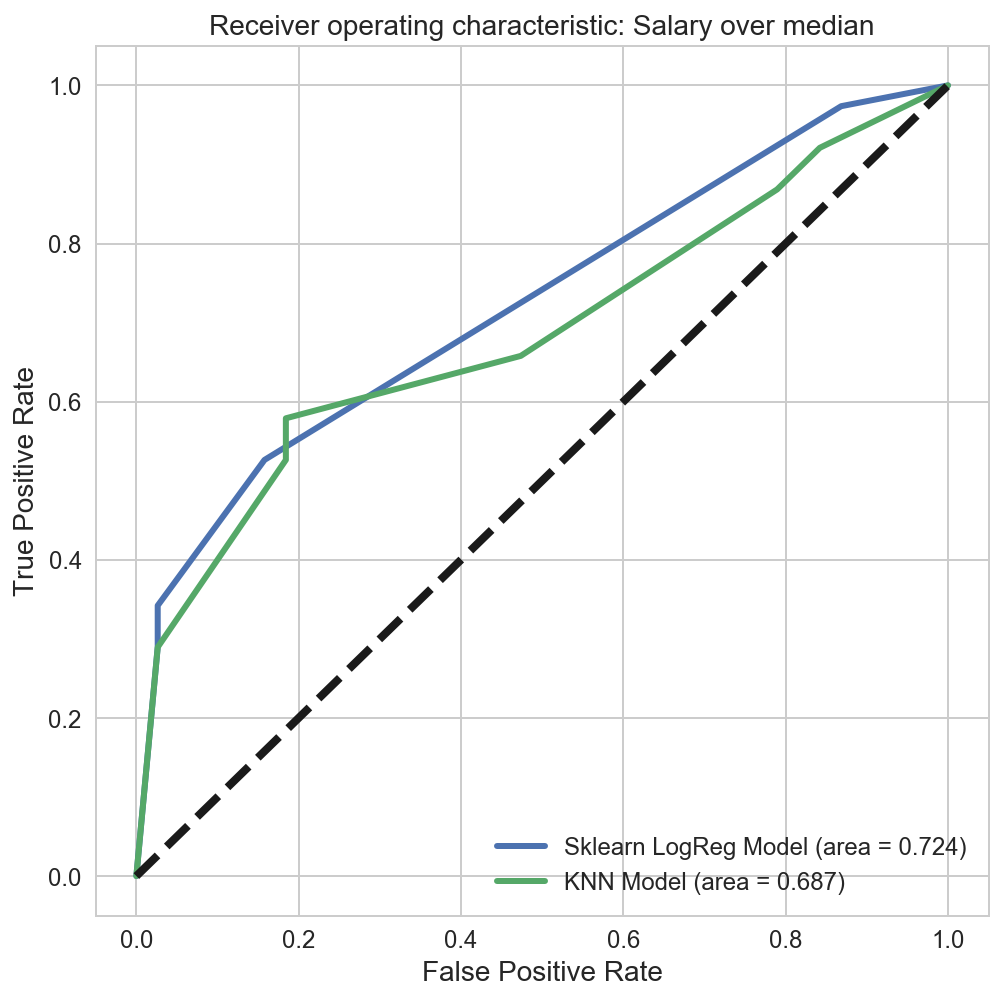

In [2318]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(conf.loc[, tpr_lr, label='Sklearn LogReg Model (area = %0.3f)' %roc_auc, linewidth=3);
ax.plot(fpr_knn, tpr_knn, label='KNN Model (area = %0.3f)' %roc_auc2, linewidth=3)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver operating characteristic: Salary over median', fontsize=14)
ax.legend(loc="lower right");

Above ROC Curve compares TPR and FPRs of both KNN and Sklearn Logistic Regression models. AUC measures for both models are 0.69 and 0.72, respectively. This suggests that Logistic Regression model has a better true positive rate than KNN model.

<b>LOGISTIC REGRESSION WITH JOB FEATURES INCLUDED</b>

In [2425]:
data = df[['city','title_Data', 'title_Scientist', 'title_Analyst', 'title_Research',
       'title_Engineer', 'title_Machine', 'title_Modeling', 'title_Statistic',
       'title_Senior', 'title_Junior', 'title_Staff', 'title_Director',
       'title_Manager', 'title_Intern', 'title_Principal', 'sal']]
data = pd.get_dummies(data)

In [2320]:
# houston has been dropped again
X = data[['title_Data', 'title_Scientist', 'title_Analyst', 'title_Research',
       'title_Engineer', 'title_Machine', 'title_Modeling', 'title_Statistic',
       'title_Senior', 'title_Junior', 'title_Staff', 'title_Director',
       'title_Manager', 'title_Intern', 'title_Principal',
       'city_Albany', 'city_Atlanta', 'city_Austin', 'city_Boston',
       'city_Boulder', 'city_Chicago', 'city_Dallas', 'city_Denver',
       'city_Long Beach', 'city_Los Angeles', 'city_Miami',
       'city_New York', 'city_Philadelphia', 'city_Phoenix', 'city_Pittsburgh',
       'city_Portland', 'city_San Diego', 'city_San Francisco',
       'city_Seattle']]
y = data['sal']

In [2321]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, stratify=y, random_state=5)

In [2322]:
gs_params = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.logspace(-3,0,50)}
gs_logreg = GridSearchCV(LogisticRegression(), gs_params, n_jobs=-1, verbose=1, cv=3)
gs_logreg.fit(X_tr, y_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [2426]:
# Model Scores, best parameters and the intercept
print('Best Model Score:', gs_logreg.best_score_)
print('Best Parameters:', gs_logreg.best_params_)
print('Accuracy Score:', gs_logreg.best_estimator_.score(X_te, y_te))
print('Coefficient for Houston:', gs_logreg.best_estimator_.intercept_)

Best Model Score: 0.6558441558441559
Best Parameters: {'C': 0.32374575428176433, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy Score: 0.6842105263157895
Coefficient for Houston: [-0.10558499]


In [2327]:
coef_df = pd.DataFrame({'coef': gs_logreg.best_estimator_.coef_[0], 'feature': X_tr.columns, 
            'abs_coef': np.abs(gs_logreg.best_estimator_.coef_[0])})
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df

,abs_coef,coef,feature
32,0.554061,0.554061,city_San Francisco
4,0.445931,0.445931,title_Engineer
0,0.408213,0.408213,title_Data
3,0.374012,-0.374012,title_Research
25,0.000000,0.000000,city_Miami
20,0.000000,0.000000,city_Chicago
21,0.000000,0.000000,city_Dallas
22,0.000000,0.000000,city_Denver
23,0.000000,0.000000,city_Long Beach
24,0.000000,0.000000,city_Los Angeles


In [2328]:
logreg_yhat = gs_logreg.best_estimator_.predict(X_te)
confusion = confusion_matrix(y_te,logreg_yhat,labels=[1,0])
pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])

,pred_high_sal,pred_low_sal
high_sal,27,11
low_sal,13,25


In [2330]:
print(classification_report(y_te, logreg_yhat, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.68      0.71      0.69        38
          0       0.69      0.66      0.68        38

avg / total       0.68      0.68      0.68        76



In [2331]:
# predicted probabilities
lr_prob = gs_logreg.best_estimator_.predict_proba(X_te)

<b>Rates at 0.7 threshold level</b>

In [2802]:
predictions_for_70 = (lr_prob[:,1]>0.7)*1

In [2803]:
confusion = confusion_matrix(y_te, predictions_for_70, labels=[1,0])
pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])

,pred_high_sal,pred_low_sal
high_sal,9,29
low_sal,0,38


In [2433]:
print(classification_report(y_te, predictions_for_70, labels=[1,0]))

             precision    recall  f1-score   support

          1       1.00      0.24      0.38        38
          0       0.57      1.00      0.72        38

avg / total       0.78      0.62      0.55        76



<b>Results of the Logistic Regression Model with added variables</b>

The model with added binary predictors created based on the job title including the following words: Data, Scientist, Analyst, Research, Engineer, Machine, Modeling, Statistic, Senior, Junior, Staff, Director, Manager, Intern, Principal.

Cross validated model returned an accuracy score of 0.68 which is very similar to the previous models. The model had a 68% precision rate at the 0.5 probability threshold and a 71% recall rate. Given the concerns about wrong higher salary predictions, I increased the probability threshold to 0.7 and as a result, the model has a high precision which indicates that the model is correct 100% of the time in predicting higher salaries.

As the regularization has been used, most of the variables weren't entered the model. Looking at the coefficients, we can see that, again, San Francisco has the largest contribution to the model. The other predictors of higher salaries are having Engineer, Data, and Research in the job title. While Engineer and Data has positive coefficients, Data has a negative coefficient meaning that a job including word Research in the title is more likely to have a salary below median.

<b>RANDOM FOREST:</b>

In [2507]:
from sklearn.ensemble import RandomForestClassifier

In [2508]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 34],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
gs_f = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=3, n_jobs=-1, verbose=1)
gs_f.fit(X_tr, y_tr)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 34], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [2509]:
# Model Scores, best parameters and the intercept
print('Best Model Score:', gs_f.best_score_)
print('Best Parameters:', gs_f.best_params_)
print('Accuracy Score:', gs_f.best_estimator_.score(X_te, y_te))

Best Model Score: 0.7012987012987013
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 34, 'min_samples_leaf': 10, 'min_samples_split': 2}
Accuracy Score: 0.6842105263157895


In [2510]:
best_rf = gs_f.best_estimator_

In [2511]:
best_rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features=34, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [2512]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = StringIO()
export_graphviz(best_rf[0], out_file=dot_data,
                feature_names=X_tr.columns,
#                 class_names=best_rf[0].feature_names,
               filled=True, rounded=True,
                proportion=True,
                special_characters=True,
                node_ids=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

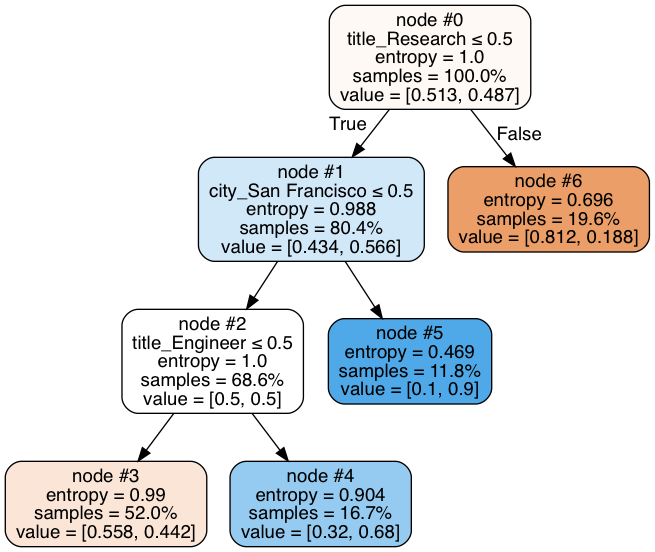

In [2513]:
Image(graph.create_png())

In [2515]:
# Feature importances
feature_im = pd.DataFrame(data=best_rf[0].feature_importances_, index=X_te.columns, columns=['importance'])
feature_im.sort_values(by=['importance'], ascending=False ).loc[feature_im.importance>0]

,importance
title_Research,0.476752
city_San Francisco,0.388689
title_Engineer,0.134559


In [2501]:
# confusion matrix
rf_yhat = gs_f.best_estimator_.predict(X_te)
confusion = confusion_matrix(y_te,rf_yhat,labels=[1,0])
pd.DataFrame(confusion, columns=['pred_high_sal', 'pred_low_sal'], index=['high_sal', 'low_sal'])

,pred_high_sal,pred_low_sal
high_sal,27,11
low_sal,13,25


In [2502]:
# classification report
print(classification_report(y_te, rf_yhat, labels=[1,0]))

             precision    recall  f1-score   support

          1       0.68      0.71      0.69        38
          0       0.69      0.66      0.68        38

avg / total       0.68      0.68      0.68        76



In [2503]:
# Predicted proabbilities
rf_prob = gs_f.best_estimator_.predict_proba(X_te)

<b>Results of Random Forest</b>

A cross validated grid search method was used again to find the optimal hyper parameters for an efficient model. Overall accuracy score for the best estimator is 0.68 similar to the previous models. Classification report indicates that the random forest model has a slightly better recall(0.71) than precision (0.68).

As can be seen in the above tree graph and the feature importance table, variables title_Research, city_San Francisco, and title_Engineer were used in deciding the higher salaries. 

<b>ROC Curve for Skelearn Logistic Regression and Random Forest:</b>

In [2518]:
fpr_rf, tpr_rf, treshold_rf = roc_curve(y_te, rf_prob[:,1])
roc_auc_df = auc(fpr_rf, tpr_rf)

In [2505]:
fpr_llr, tpr_llr, treshold_llr = roc_curve(y_te, lr_prob[:,1])
roc_auc_llr = auc(fpr_llr, tpr_llr)

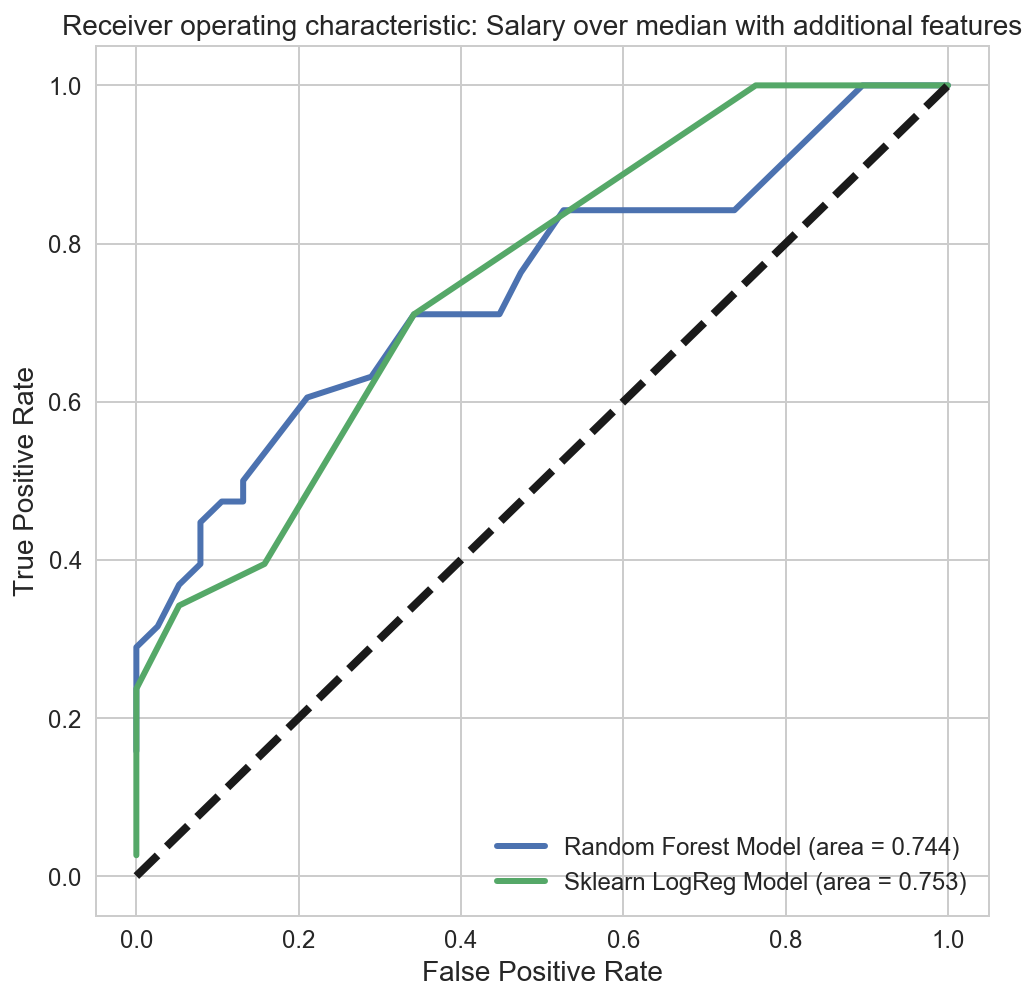

In [2506]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr_rf, tpr_rf, label='Random Forest Model (area = %0.3f)' %roc_auc_df, linewidth=3);
ax.plot(fpr_llr, tpr_llr, label='Sklearn LogReg Model (area = %0.3f)' %roc_auc_llr, linewidth=3)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver operating characteristic: Salary over median with additional features', fontsize=14)
ax.legend(loc="lower right");

As the results and the above ROC curve suggests, Logistic Regression has a overall better performance than Random Forest Model in prediction using title and location features as predictors.

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

The dataset that I used for the analyses consists of data scientist job adverts in 20 different cities in the USA. Data was scraped from indeed.com website using keywords 'data', 'scientist' and the city name. The number results per city were set to 5000, which yielded an initial dataset with around 90000 observations. However, the number of unique observations were not that high and when the data cleaning criteria were applied, the size of the sample was reduced to 230. In order to label the salaries, the median of the salary distribution was used as a threshold value (97436.0) such that the salaries that were higher than this value were labelled as high and the salaries that are below this threshold were labelled as low. The city with the highest number of data points (n=30), San Francisco, also had the highest proportion of higher salaries within this sample. 

To predict the higher salaries based on location, I tried both Logistic Regression and KNN classifiers. Logistic Regression model performed better with an accuracy score of 0.68 showing that it was better than the random guess (5% probability) which actually equals to the baseline accuracy in this sample. 

Logistic Regression model calculates probabilities of belonging to both classes for each data point and after that, the group memberships are decided based on a threshold level such as 0.5. At this threshold level, the model had a 77% precision and a 53% recall rate. These values illustrate how effective the model is in predicting the high salaries. The model was correct 77% of the time when it classified a data point as high salary whereas it was able to classify only 53% of the high salaries correctly.

Given the concerns about wrong higher salary classifications, I increased the probability threshold to 0.7 and as a result, the model had a 92% precision rate which in this case is a preferable measure as we want to make true positive classifications rather than mistakenly classifying a low salary as high. 

Predictor cities that contributed to this model are San Francisco, Seattle, Chicago, Miami, Pittsburgh and Phoenix. Houston was dropped from the model as the mean salaries in this city was in the middle among all the cities. Thus, the results are evaluated in comparison to its log odds ratio. The odds ratio explains the relationship between changes in the values of an independent variable and the odds of event outcome. Looking at the coefficients, we can see that, a job in San Francisco is almost 10 times more likely to be in higher salary range in comparison to a job Houston. Other cities with smaller, but positive coefficients are Seattle and Chicago and the salaries are more likely to be in the higher range. The cities in the model such as Miami, Pittsburgh and Phoenix are more likely to have jobs being in the lower salary group.

For the second model, I added some boolean variables in terms of having certain words in the job title such as Senior, Junior, Data, Scientist, Engineer, and Analyst. The next models were run adding these 15 job title features to the city variables. Similar to the previous approach, I used two different models and compared their performances in classification.

The Logistic Regression model had a 0.68 accuracy which is similar to the previous models. At the 0.5 probability threshold the precision rate was 68% and recall rate was 71%. In order to increase precision, I increased the probability threshold to 0.7 and as a result, the model had a precision of 1, which indicates that the model is correct 100% of the time in predicting higher salaries even though the total number of high predictions is 9.

San Francisco is a positive predictor of high salary, along with having Engineer, Data, and Research in the job title. While Engineer, Data, San Francisco has positive coefficients, Research has a negative coefficient meaning that a job including word Research in the title is more likely to have a lower salary.

The results of my second classifier, Random Forest returned the same accuracy score and precision rate with the Logistic Regression model with the same feature set. As expected, the variables contributed to the model were Research and Engineer words in the title and San Francisco as the city. 

All the models were trained on 77.7% of the data and cross-validated before tested on the held-out testing set. Although the variation and the size of the sample were limited in all of the models, the results were fairly generalizable with different partitions. Increasing the classification threshold helped to increase the precision but the number of predictions made correctly was still quite low. Finally, overall predictors of the salary are San Francisco, Data, and Engineer.

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 